# Sentiment of Threads over the course of time

In [2]:
%pip install readability

  Using cached https://files.pythonhosted.org/packages/26/70/6f8750066255d4d2b82b813dd2550e0bd2bee99d026d14088a7b977cd0fc/readability-0.3.1.tar.gz
  Created wheel for readability: filename=readability-0.3.1-cp37-none-any.whl size=35465 sha256=7d1b1c9d5741a98dead7bdbef742b3910eaad2f7b8ac15de91a8021b28c22cae
  Stored in directory: C:\Users\Jasper\AppData\Local\pip\Cache\wheels\36\3f\65\bc327f4cdd5bff9ff510834e07522f94389e28858311b33b41
Successfully built readability
Note: you may need to restart the kernel to use updated packages.


In [20]:
# import libraries
import pandas as pd
import numpy as np
import string
import spacy.cli
import matplotlib.pyplot as plt
import pdtext
import readability
from pdtext.tf import word_count
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jasper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
df = pd.read_csv('df_final.csv')

In [4]:
# much of the text is missing; thus, we keep only the data with text
missing = (df["text"].isnull()) | ((df["text"] == '[deleted]')) | ((df["text"] == '[removed]'))
df = df.loc[~missing]

In [5]:
##############################
# clean the text in df for LDA
##############################
# stemming
eng_stemmer = SnowballStemmer("english")

def stem_sentence(sentence):
    new_sentence = ''
    for word in word_tokenize(sentence):
        new_sentence = new_sentence + ' ' + eng_stemmer.stem(word)
    return new_sentence.strip()

def clean_text(s, stem = True):
    # remove numbers: https://stackoverflow.com/questions/12851791/removing-numbers-from-string
    s = ''.join([i for i in s if not i.isdigit()])
    # remove punctuation:
    s = s.translate(str.maketrans('', '', string.punctuation))
    # stem
    if stem:
        s = stem_sentence(s)
    return(s)

# get clean text from which to extract topics
clean_text_df = df['text'].apply(clean_text)

clean_text_df = pd.DataFrame(clean_text_df, index=df.index)

# NOTE: a lot of the results are null. Get rid of them!
#is_null = clean_text_df.isnull()
#clean_text_df = clean_text_df.loc[~is_null]
# also do the same with the original df
#df = df.loc[~is_null]

clean_text_df.shape[0] == df.shape[0] # True, good

True

In [7]:
%pip install vaderSentiment

  Using cached https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [8]:
###########
# sentiment
###########
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
fn_analyzer = lambda x: analyzer.polarity_scores(x)['compound']

# warning --slow
sentiment = df['text'].apply(fn_analyzer)

sentiment.head()

3     0.1139
6     0.5173
8    -0.2168
11   -0.5210
21   -0.1779
Name: text, dtype: float64

In [13]:
days = df[df.index == clean_text_df.index]['Day']

clean_text_df['Day'] = days
clean_text_df['Sentiment'] = sentiment

Text(0.5, 1.0, 'Histogram of Thread Sentiment')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


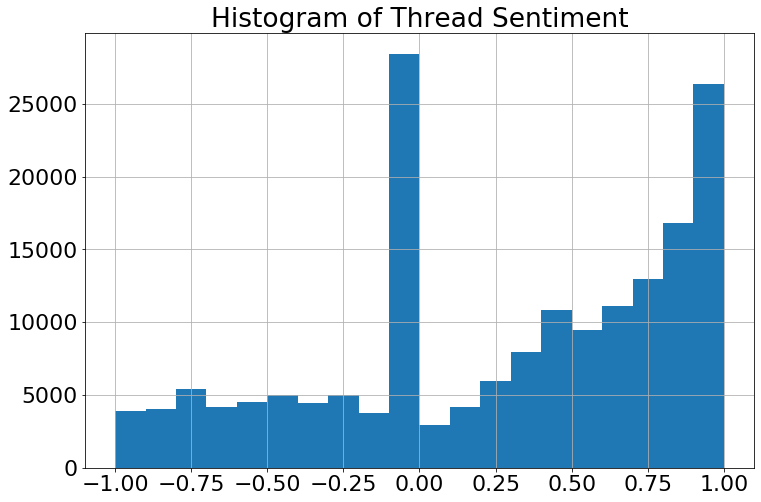

In [22]:
plt.figure(figsize=(12,8))
clean_text_df['Sentiment'].hist(bins=20);
plt.title('Histogram of Thread Sentiment')

In [40]:
# Grouping by day
sent = clean_text_df.groupby('Day').sum()
sent['Mean'] = clean_text_df.groupby('Day').mean()
sent['Var'] = clean_text_df.groupby('Day').var()

In [42]:
sent.index = pd.DatetimeIndex(sent.index)

In [44]:
sent.columns = ['Sum','Mean', 'Var']
sent

Sum      Mean       Var
Day                                    
2016-01-01   8.7372  0.291240  0.317775
2016-01-02  11.6934  0.238641  0.284214
2016-01-03  14.4449  0.328293  0.258144
2016-01-04  16.2673  0.378309  0.369404
2016-01-05  19.2291  0.300455  0.324097
...             ...       ...       ...
2020-12-27  44.2725  0.265105  0.225401
2020-12-28  53.6090  0.355026  0.259130
2020-12-29  69.4254  0.357863  0.265242
2020-12-30  99.5231  0.333970  0.257221
2020-12-31  83.5553  0.327668  0.292800

[1827 rows x 3 columns]

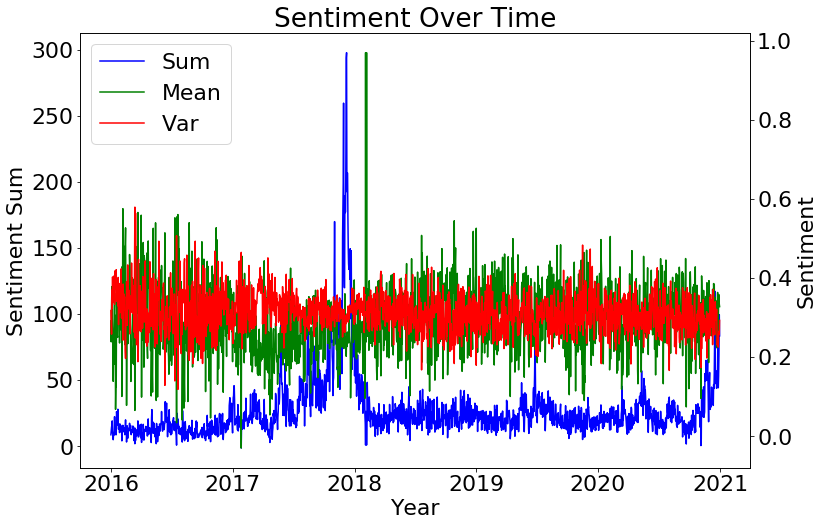

In [46]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()

ln1 = ax1.plot(sent.index, sent['Sum'], label='Sum', color='b')
ln2 = ax2.plot(sent.index, sent['Mean'], label='Mean', color='g')
ln3 = ax2.plot(sent.index, sent['Var'], label='Var', color='r')

ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment Sum')
ax2.set_ylabel('Sentiment')

lns = ln1 + ln2 + ln3 
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, loc='upper left')
plt.title('Sentiment Over Time')
plt.show()

Quite ugly.

Text(0.5, 1.0, 'Summed Sentiment per Day over Time')

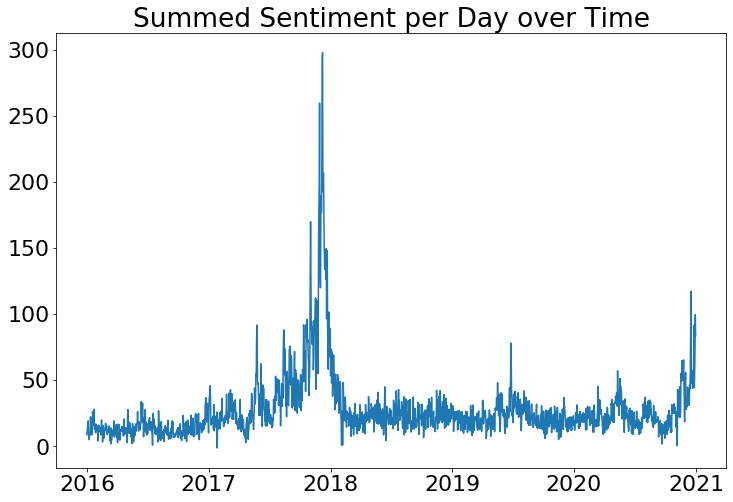

In [48]:
plt.figure(figsize=(12,8))
plt.plot(sent.index, sent['Sum'])
plt.title('Summed Sentiment per Day over Time')
plt.xlabel('Year')
plt.ylabel('')

In [54]:
sentsort = sent.sort_values('Sum')
sentsort

Sum      Mean       Var
Day                                     
2017-01-26   -1.2764 -0.029684  0.464743
2020-11-05    0.5752  0.095867  0.173729
2016-07-16    0.9208  0.034104  0.506846
2018-02-06    0.9693  0.969300       NaN
2018-02-03    0.9693  0.969300       NaN
...              ...       ...       ...
2017-12-10  206.5755  0.256616  0.306266
2017-12-06  221.3378  0.243228  0.289335
2017-11-29  259.4813  0.240706  0.266326
2017-12-07  293.7947  0.202060  0.284554
2017-12-08  297.6220  0.253511  0.308779

[1827 rows x 3 columns]